<a href="https://colab.research.google.com/github/dkaratzas/XNAP_Profs/blob/main/W04_01_MLP_for_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP for image classification

In this notebook we are going to learn how to use a Multi-Layer Perceptron (MLP) for clasifing images. 

A MLP like the ones you used in the notebook of last week can be used with any kind of input data if we can represent it with a vector of real numbers. The shape of the input vector determines the size of the first layer in the model. In the case of images (2d arrays of pixel values) we can get fixed-lenght vectors by: (1) using images of the same size in all our dataset, and (2) flatenning the images into a 1d array. The flatten operation collapses an array into one dimension. For example, if we have a grayscale image of 28*28 pixels, its flattened version is a 1d array of 784 pixel values. Now we can fed these 784 values into a MLP for classifiying the image.

### Import the necessary libraries

In [1]:
import torch #should be installed by default in any colab notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

### Use GPU if available

In [2]:
# If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## The Fashion-MNIST dataset

[**Fashion-MNIST**](https://pytorch.org/vision/0.8/datasets.html#fashion-mnist) is a dataset consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. It was poroposed as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

Each training and test example is assigned to one of the following labels: 0 T-shirt/top, 1 Trouser, 2 Pullover, 3 Dress, 4 Coat, 5 Sandal, 6 Shirt, 7 Sneaker, 8 Bag, 9 Ankle boot.

The Fashion-MNIST dataset is available in [torchvision](https://pytorch.org/vision/stable/index.html) and can be loaded with the following code:


In [3]:
train_set = datasets.FashionMNIST("data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
val_set = datasets.FashionMNIST("data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

print(train_set.data.size(), val_set.data.size())
print(train_set.targets.size(), val_set.targets.size())

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])
torch.Size([60000]) torch.Size([10000])


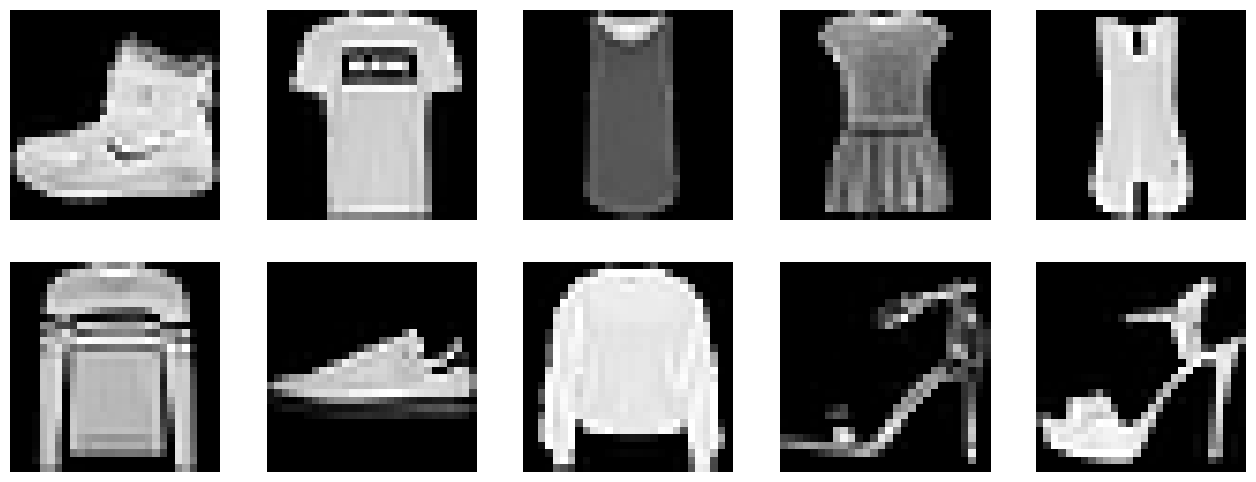

In [4]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image = train_set.data[i,...]
    plt.imshow(image.squeeze().numpy(), cmap="gray")
    plt.axis('off');

In [5]:
from sklearn.manifold import TSNE


flattened_data = val_set.data.flatten(start_dim=1, end_dim=2)
gt_val =  val_set.targets

# Project the data into 2 dimensions
X_dev_tsne = TSNE(n_components=2).fit_transform(flattened_data)

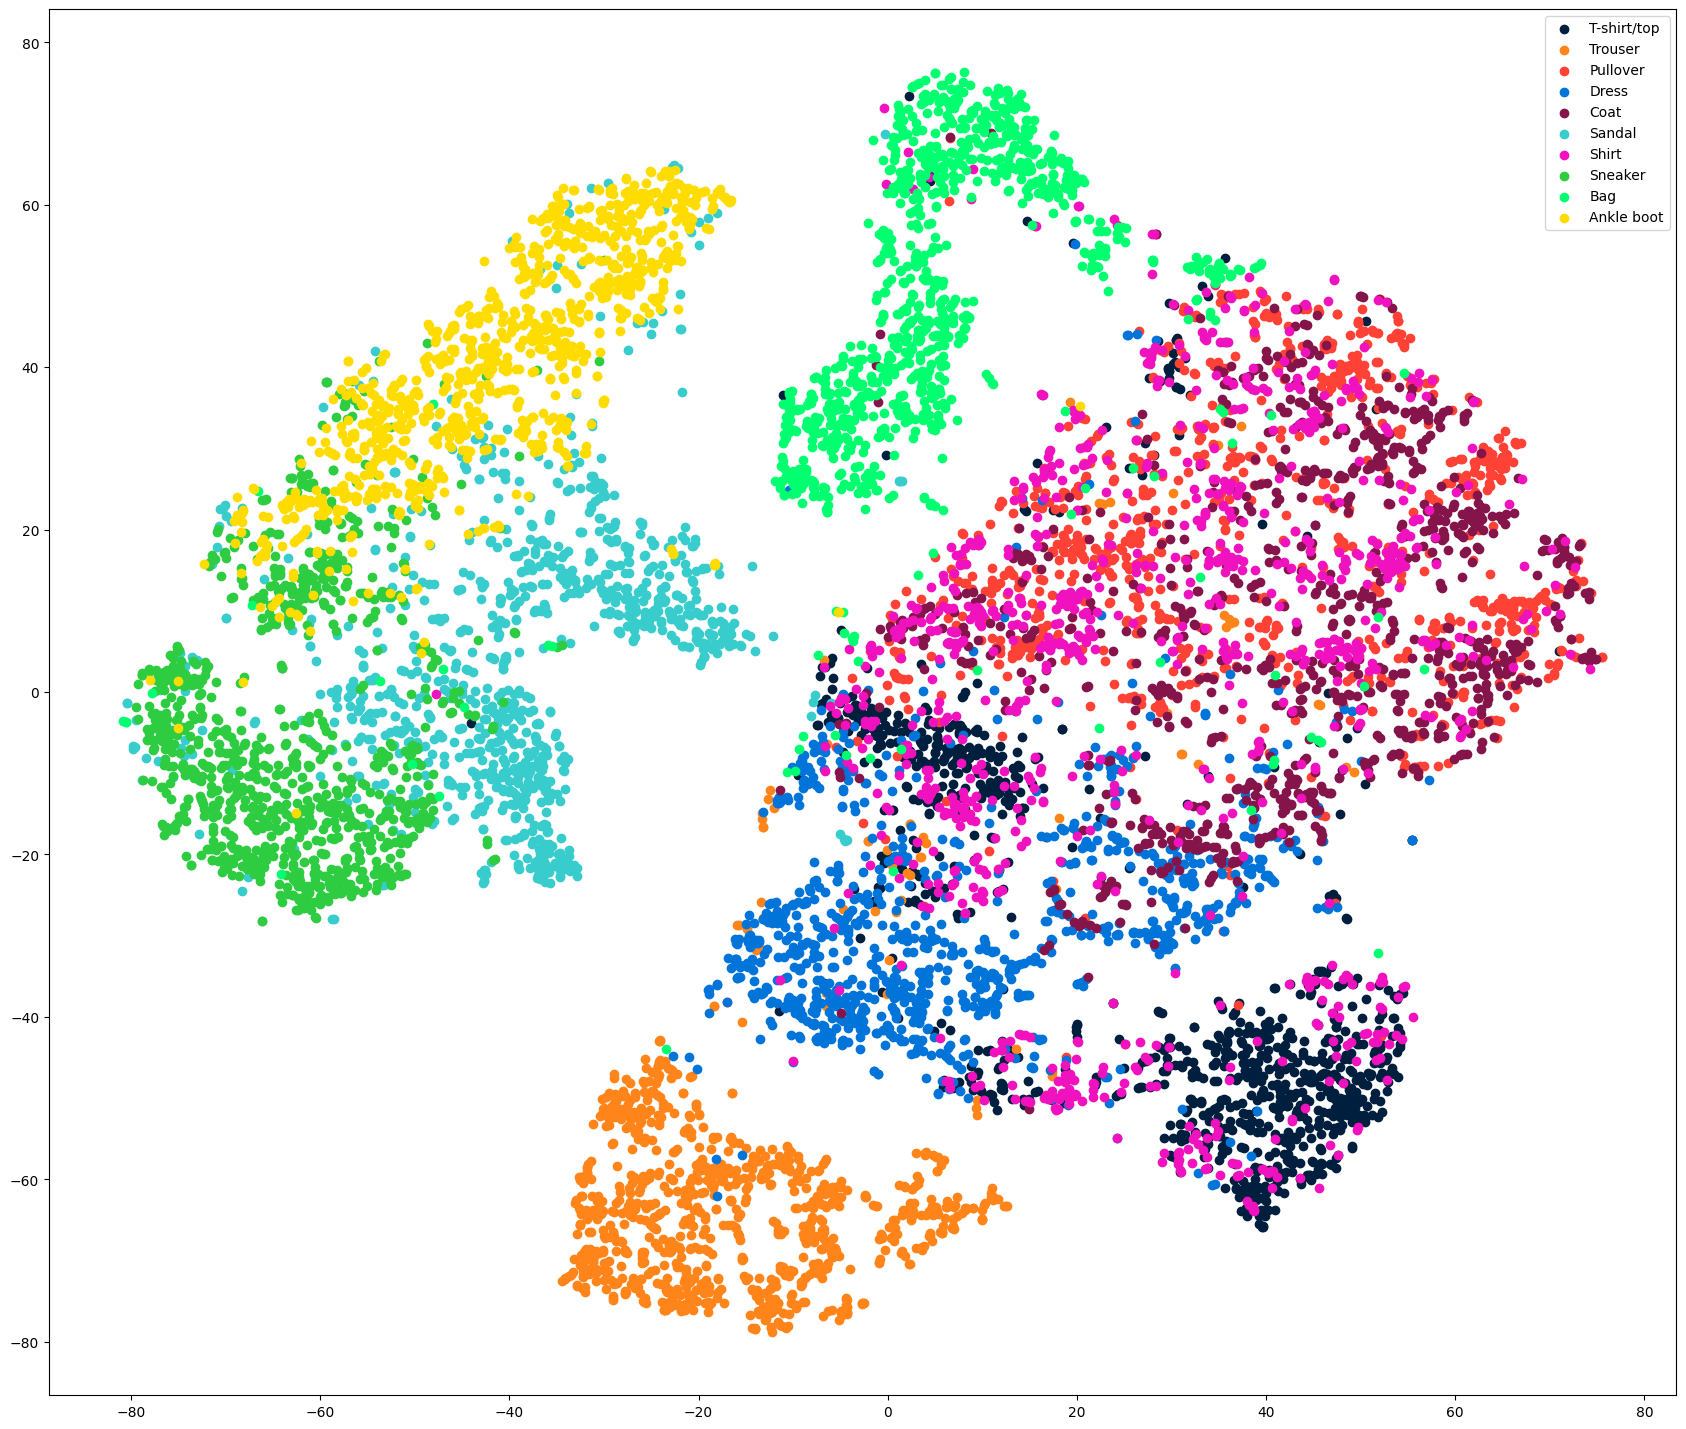

In [6]:
import numpy as np
from ast import literal_eval



colors = ['rgb(0,31,63)', 'rgb(255,133,27)', 'rgb(255,65,54)', 'rgb(0,116,217)', 'rgb(133,20,75)', 'rgb(57,204,204)',
'rgb(240,18,190)', 'rgb(46,204,64)', 'rgb(1,255,112)', 'rgb(255,220,0)',
'rgb(76,114,176)', 'rgb(85,168,104)', 'rgb(129,114,178)', 'rgb(100,181,205)']


labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
         'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def plot_embedding_v1(X_embeded, y):
    plt.rcParams["figure.figsize"] = [21, 18]
    for k, i in enumerate(np.unique(y.astype(np.int32()))):
        plt.scatter(X_embeded[y == i, 0],
                   X_embeded[y == i, 1],
                   color = '#%02x%02x%02x' % literal_eval(colors[k][3:]), 
                    label = labels[k])
    plt.legend()
    plt.show()

plot_embedding_v1(X_dev_tsne, gt_val.numpy())

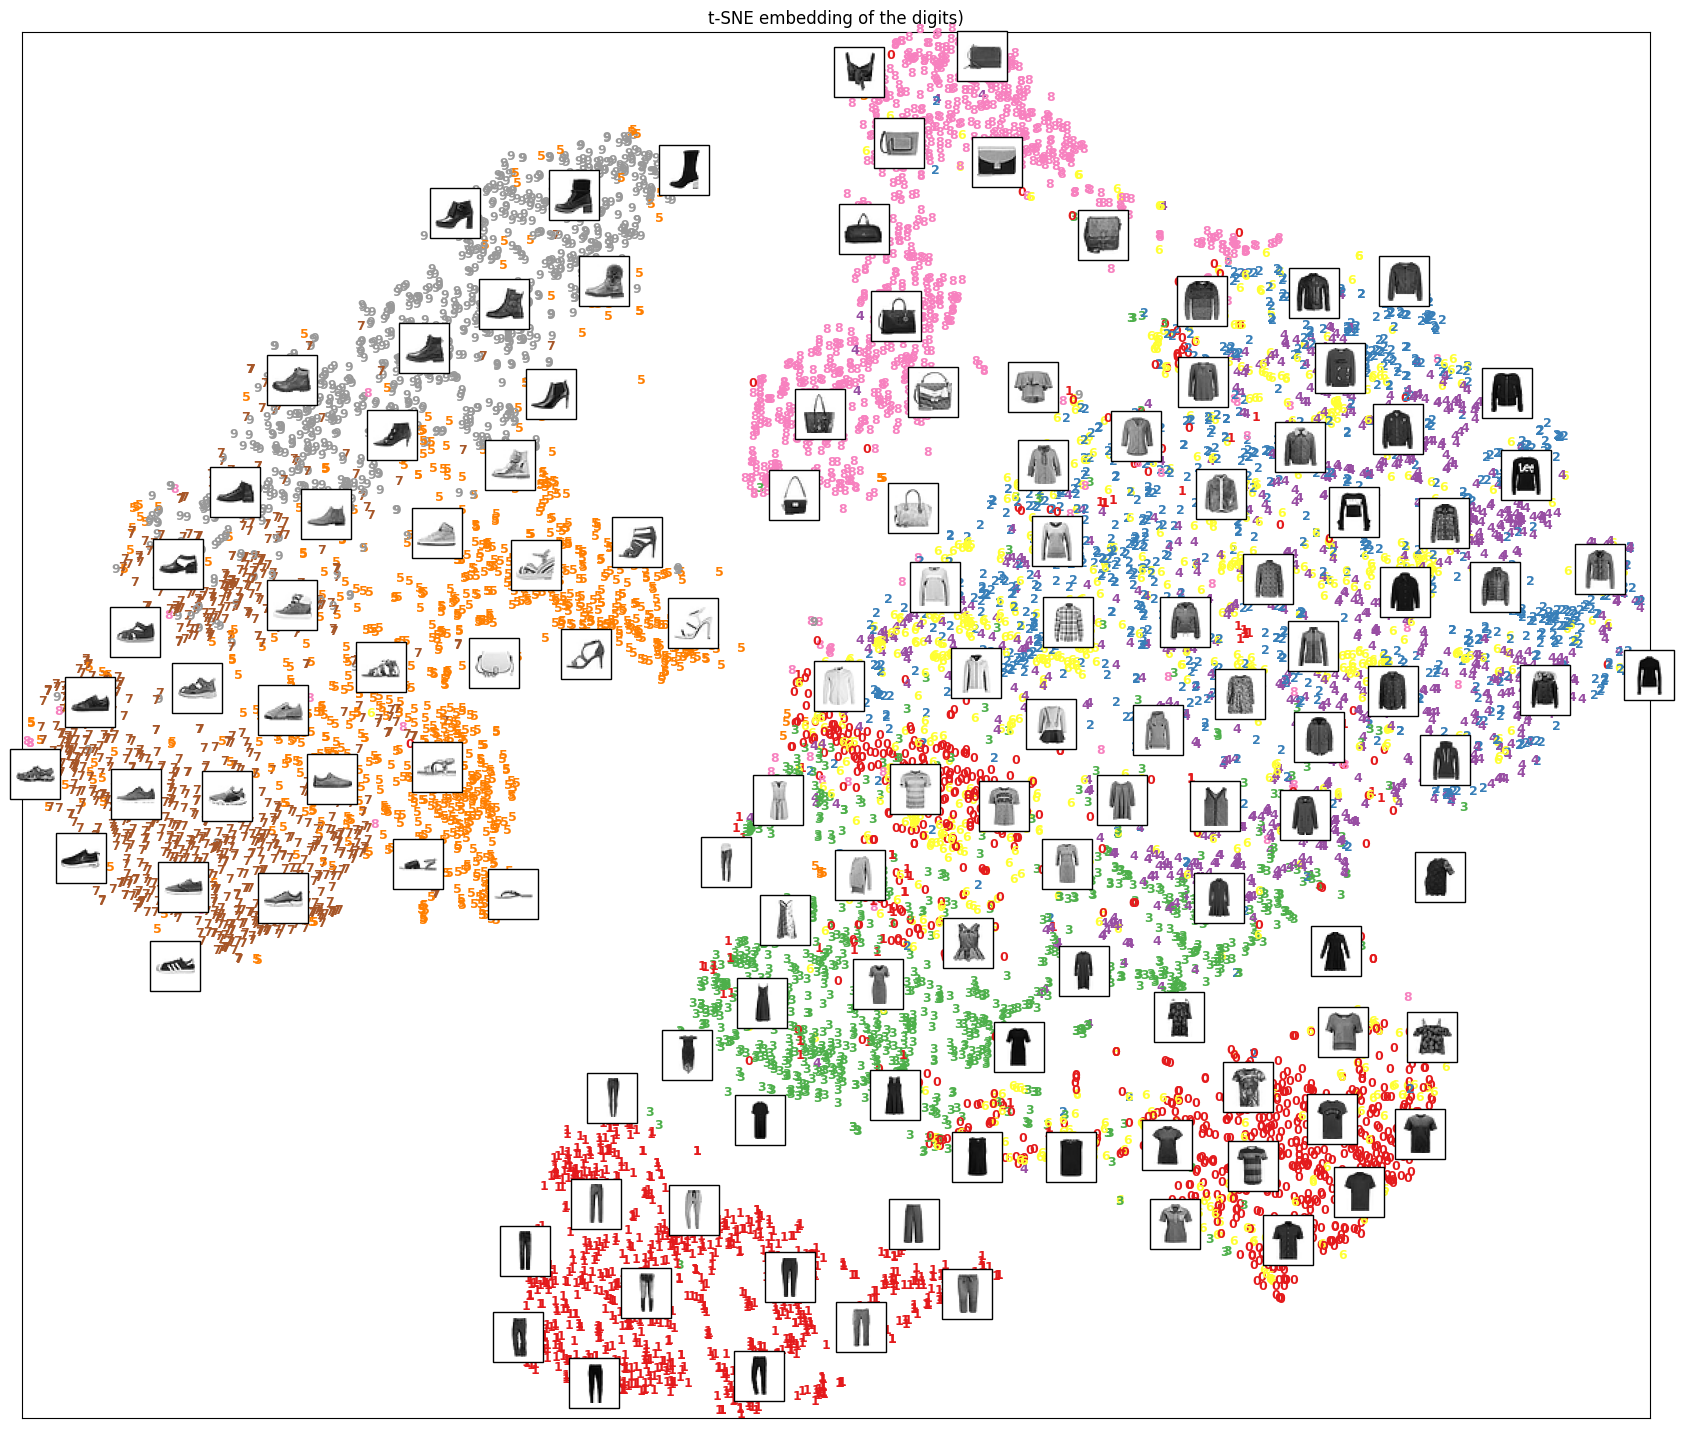

In [7]:
# Visualize the embedding vectors
from matplotlib import offsetbox

def plot_embedding_v2(X, X_origin, y_dev,  title=None, dims=[None, 28, 28]):
    dims[0] = X.shape[0]
    X_origin = X_origin.astype(np.float32).reshape(dims)
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y_dev[i]),
                 color=plt.cm.Set1(y_dev.astype(np.int32)[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 3e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(X_origin[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
        
plot_embedding_v2(X_dev_tsne, flattened_data.numpy(), gt_val.numpy(),  "t-SNE embedding of the digits)")


## The dataloaders

Now we introduce a **critical piece in any deep learning training process**: the dataloader. In Pytorch we can create a dataloader for a given dataset as follows:


In [8]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=60, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=60, shuffle=False, num_workers=2)

# Exercise 1

1.1. Take a look at the documentation of [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) and answer the following questions:

- What are the benefits of a dataloader?
- How can we make the dataloaders defined above better? 

1.2. When we loaded the Fashion-MNIST dataset we used the method `transforms.Compose`. Take a look at the documentation of [torchvision.transforms](https://pytorch.org/vision/0.8/transforms.html?highlight=transforms) and answer the following question:

- Is there another transform that we can add to make our classification problem easier?

# Excersice 2

Modify your best performing architecture from last week notebook and create a class model that can work for any input and output size (using the `__init__()` class constructor parameters)

### Fully connected model

In [9]:

class FCModel(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FCModel, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            # Your code here 
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size),
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

## Parameter Initialization

In PyTorch the default parameter initialization depends on the layer type. For example, for the Linear layer the default initialization is defined [here](https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py#L87). Take a look and see if you recognize the initialization method.

You can find more initialization methods in the [`torch.nn.init`](https://pytorch.org/docs/stable/nn.init.html?highlight=init) module.

If necessary, you can change the default initialization of a layer as follows:

In [10]:
def initialize_parameters(model):
    for name, w in model.named_parameters():
        if "weight" in name:
            nn.init.uniform_(w, -0.1, 0.1)
        
        if "bias" in name:
            nn.init.uniform_(w, -0.1, 0.1)   

## Create the model and initialize its parameters

In [11]:
learning_rate = 1e-3
lambda_l2 = 1e-5
torch.manual_seed(0) # seed for reproductibility

input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

model = FCModel(input_size, 128, output_size)

# utility function to count number of parameters in a model
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.numel()
    return np

print(f"Number of parameters {get_n_params(model)}:")

# move model to gpu if available
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=lambda_l2) # built-in L2

# WARNING! What are we doing here?
initialize_parameters(model)

Number of parameters 118282:


## Define the train and validation methods

In [12]:
@torch.no_grad()  # prevent this function from computing gradients 
def validate(criterion, model, loader):

    val_loss = 0
    correct = 0

    model.eval()

    for data, target in loader:

        data, target = data.to(device), target.to(device)

        data = data.view(-1, 28*28)
        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()                                                              
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(loader.dataset),
        accuracy))


    return val_loss


def train(epoch, criterion, model, optimizer, loader):
    
    total_loss = 0.0

    model.train()

    for batch_idx, (data, target) in enumerate(loader):
        
        optimizer.zero_grad()

        data, target = data.to(device), target.to(device)

        data = data.view(-1, 28*28)

        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        # print loss every N iterations
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item()))


        total_loss += loss.item()  #.item() is very important here? Why?

    return total_loss / len(loader.dataset)

### The training loop

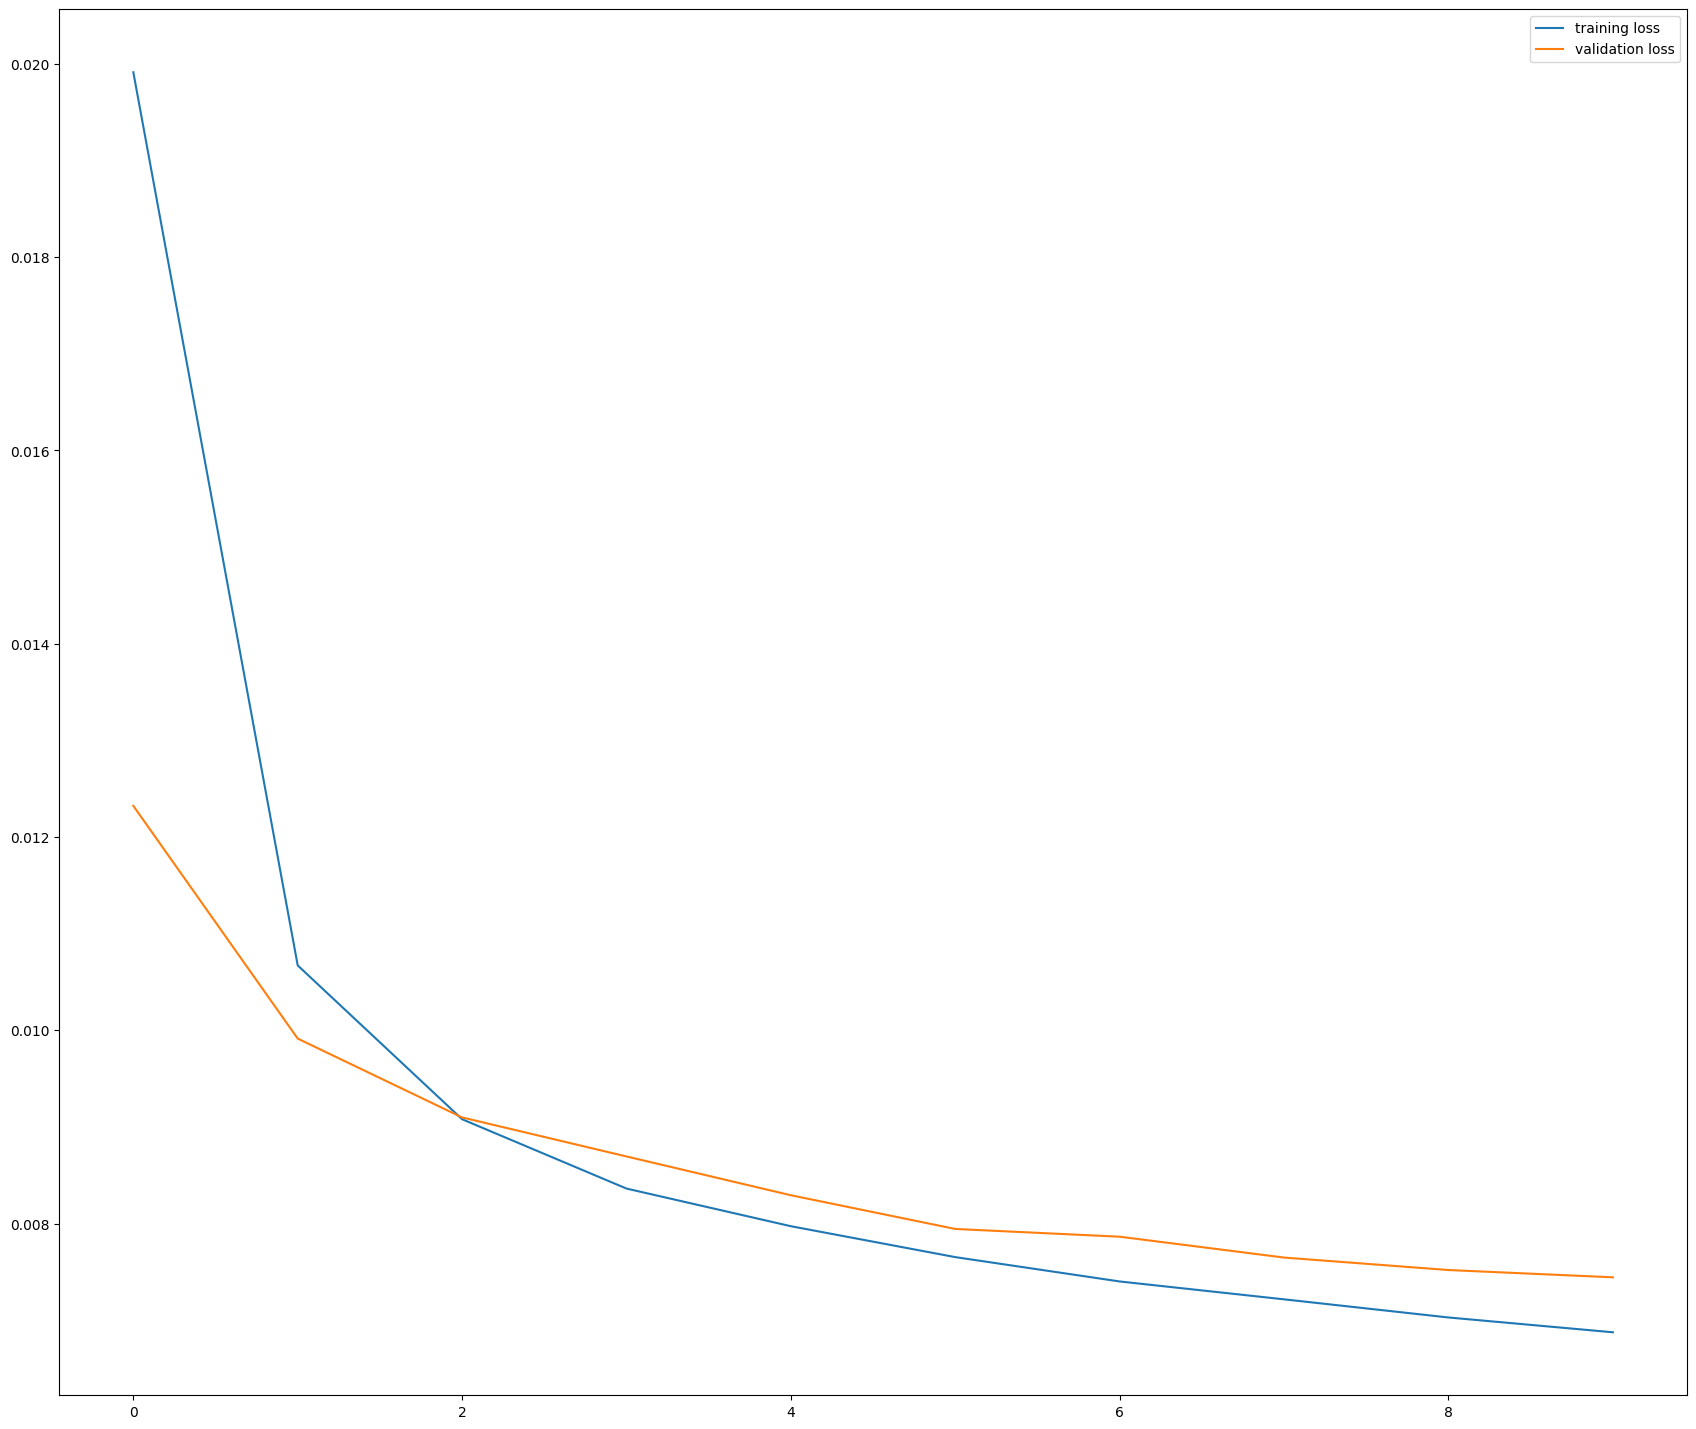

In [13]:
losses = {"train": [], "val": []}
for epoch in range(10):

    train_loss = train(epoch, criterion, model, optimizer, train_loader)
    val_loss = validate(criterion, model, val_loader)
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)
    
    display.clear_output(wait=True)

    plt.plot(losses["train"], label="training loss")
    plt.plot(losses["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()   

# Homework

A) Change the initialization of the model parameters (this will help a great deal) and train your model on the Fashion-MNIST dataset.



In [14]:
# Your code here
def initialize_parameters(model):
    for name, w in model.named_parameters():
        if "weight" in name:
            nn.init.uniform_(w, -0.1, 0.1)
        
        if "bias" in name:
            nn.init.uniform_(w, -0.1, 0.1)   

B) Try to improve the Accuracy of your model on the validation set by adding more layers and/or more hidden units in you model. For example you can use a MLP with 2 hidden layers with 512 and 256 units respectively.

In [15]:
# Your code here

class FCModel(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FCModel, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            # Your code here 
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, output_size),
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

C) Try at least two different [optimizers](https://pytorch.org/docs/stable/optim.html#algorithms) (e.g. SGD with momentum, RMSProp, Adam, etc.) and plot **in a single matplotlib figure** the loss curves for training the model with them. We want them in a single figure to be able to easily compare the three learning curves.


Training SGD
Number of parameters: 535818
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.454676

Test set: Average loss: 0.0199, Accuracy: 6577/10000 (66%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.255355

Test set: Average loss: 0.0154, Accuracy: 7008/10000 (70%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.944146

Test set: Average loss: 0.0134, Accuracy: 7341/10000 (73%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.794928

Test set: Average loss: 0.0123, Accuracy: 7548/10000 (75%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.782695

Test set: Average loss: 0.0115, Accuracy: 7654/10000 (77%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.751176

Test set: Average loss: 0.0109, Accuracy: 7801/10000 (78%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.667347

Test set: Average loss: 0.0105, Accuracy: 7895/10000 (79%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.561532

Test set: Average loss: 0.0101, Accuracy: 7949/10000 (79%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.676466

Test set: Average loss: 0.0098, Accuracy: 8018/10000 (80%)

Tra

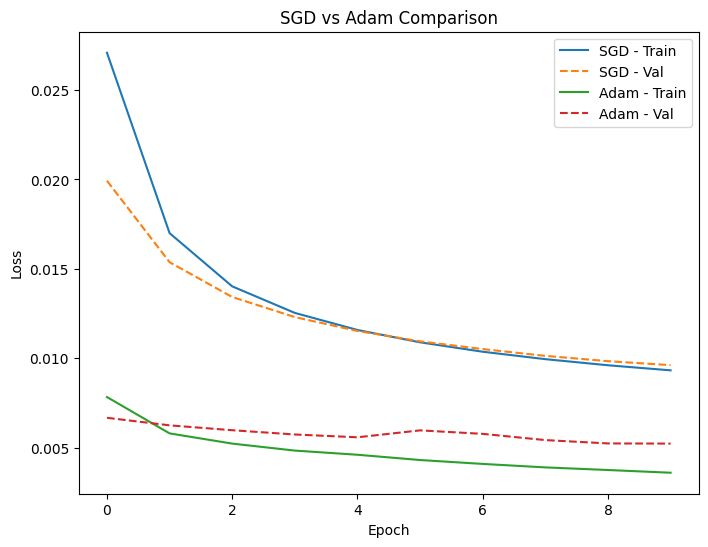

In [18]:
learning_rate = 1e-3
lambda_l2 = 1e-5
torch.manual_seed(0)

input_size  = 28*28
output_size = 10

model_sgd = FCModel(input_size, None, output_size)
model_adam = FCModel(input_size, None, output_size)

models = {
    "SGD": model_sgd,
    "Adam": model_adam
}

all_losses = {}

for name, model in models.items():

    print(f"\nTraining {name}")
    print(f"Number of parameters: {get_n_params(model)}")

    model.to(device)
    initialize_parameters(model)

    criterion = torch.nn.CrossEntropyLoss()

    if name == "SGD":
        optimizer = torch.optim.SGD(
            model.parameters(),
            lr=learning_rate,
            weight_decay=lambda_l2
        )
    else:
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=learning_rate,
            weight_decay=lambda_l2
        )

    losses = {"train": [], "val": []}

    for epoch in range(10):
        train_loss = train(epoch, criterion, model, optimizer, train_loader)
        val_loss = validate(criterion, model, val_loader)

        losses["train"].append(train_loss)
        losses["val"].append(val_loss)

    all_losses[name] = losses


# 🔥 Plot everything together
plt.figure(figsize=(8,6))

for name in all_losses:
    plt.plot(all_losses[name]["train"], label=f"{name} - Train")
    plt.plot(all_losses[name]["val"], linestyle="--", label=f"{name} - Val")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SGD vs Adam Comparison")
plt.legend()
plt.show()

D) Calculate the Accuracy for each individual class in the dataset and plot the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html#sklearn.metrics.plot_confusion_matrix) of your trained models.

In [ ]:
# Your code here

E) Study the behaviour of the Model when you apply some geometrical change in the Images. Does the accuracy is the same as before?.